<a href="https://colab.research.google.com/github/byteLm/rs/blob/main/downloading_data_and_plot_seixas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading satellite data with geemap**


## **Dependencies**

In [ ]:
# !pip install geemap
# !pip install geedim
# !pip install rasterio
import ee
import geemap
import os
import time
import datetime
import concurrent.futures
from google.colab import drive
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2
drive.mount('/content/drive')
# ee.Authenticate()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Region of interest (ROI)**


We can use a interative map from GEEMAP to determine the ROI to be downloaded.
Use 'rectangle' to delimite the ROI, the last drawn will be the rectangle variable

In [ ]:
Map = geemap.Map()
Map


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=nqWUVB7lAMSNK8X2LLn5M0gYIKXm8JSIDHg7A9kneEw&tc=QSBPQLrxb5v4VUhOir8gRcO6IhQmf-leUid5_GeH_fg&cc=HNim9Ojts7OD-wHeOy1BhqGjCiin0ve-_6i7gnl4inE

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ATx3LY5qn_RgXC2NYGc_yYga5MOZBs45dUcpI6psyYQB5oH-t14CdedO7w0

Successfully saved authorization token.


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# You can use DMS too
# def dms_to_dd(degrees, minutes, seconds):
#     dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
#     return dd

# Jeddah e.g.
# coords_jeddah = [
#     [dms_to_dd(20, 13, 55), dms_to_dd(38, 15, 31)],
#     [dms_to_dd(22, 5, 25), dms_to_dd(39, 40, 0)]
# ]


# Draw any shapes on the map using the Drawing tools before executing this code block
feature = Map.draw_last_feature

if feature is None:
    geom = ee.Geometry.Polygon(
        [
            [
                [-34.801250428054345, -7.17758105527224],
                [-34.7904357613063,-7.17758105527224],
                [-34.7904357613063,-7.1441126966631],
                [-34.801250428054345,-7.1441126966631],
                [-34.801250428054345,-7.17758105527224],
            ]
        ]
    )
    feature = ee.Feature(geom, {})

rectangle = feature.geometry()
Map.addLayer(rectangle)



## **Downloading data**

In [ ]:
# avaliable dates
def ymdList(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"));
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).reduce(ee.Reducer.frequencyHistogram()).getInfo().keys())

In [ ]:
# Time range
# from_that_date = "1983-01-01"
# to_this_date = "2025-12-31"

# bands = ['B4', 'B3', 'B2', 'B8' ] # descomment with you want select specific bands
# collection_sr = 'LANDSAT/LT05/C02/T1_L2'
# collection_sr = 'LANDSAT/LC08/C02/T1_L2'

# If u want 2009 and 2012, u need to download from Landsat 7
collection_sr = 'LANDSAT/LE07/C02/T1_L2'
# from_that_date = "2009-01-01"
# to_this_date = "2009-12-31"
from_that_date = "2012-01-01"
to_this_date = "2012-12-31"

# Data collection wich will be downloaded
download_collection_sr = ee.ImageCollection(collection_sr)\
.filterDate(from_that_date, to_this_date)\
.filterBounds(rectangle)
# .select(bands)\


In [ ]:
datas_SR = ymdList(download_collection_sr)

print("qt. of images at SR: ", download_collection_sr.size().getInfo())
print(datas_SR, '\n')


qt. of images at SR:  19
['20120107', '20120208', '20120224', '20120327', '20120412', '20120428', '20120514', '20120530', '20120615', '20120701', '20120717', '20120802', '20120903', '20120919', '20121005', '20121021', '20121106', '20121208', '20121224'] 



In [ ]:
def get_image_date(image):
    return image.date().format('YYYY-MM-dd').getInfo()

In [ ]:
# e.g. REGION
REGION = 'Seixas'

def format_date(date_string):
    date = datetime.datetime.strptime(date_string, "%Y%m%d")
    return date.strftime("%Y-%m-%d")

# Define a function to export a single image
def export_image(date_image_pair):
    date, image = date_image_pair
    dest_folder =  os.path.join(folder, date[:4])
    filename = REGION+'_'+date.replace('-', '')+".tif"
    os.makedirs(dest_folder, exist_ok=True)
    geemap.ee_export_image(image, filename= dest_folder+'/'+filename, scale=30, region=rectangle, file_per_band=False)


def mosaic_by_date(imcol):
    string_dates_list = ymdList(imcol)
    string_dates_list = [format_date(date) for date in string_dates_list]

    print(string_dates_list)
    imlist = imcol.toList(imcol.size())

    mosaic_list = [ee.Image(ee.ImageCollection(imcol.filterDate(date, ee.Date(date).advance(1, 'day'))).mosaic()) for date in string_dates_list]
    mosaic_dict = dict(zip(string_dates_list, mosaic_list))
    return mosaic_dict

In [ ]:
n_threads = 1

# Apply the function to your collection
mosaic_dict = mosaic_by_date(download_collection_sr)
folder = "/content/drive/MyDrive/{}/original/6B/".format(REGION)

with concurrent.futures.ThreadPoolExecutor(max_workers = n_threads) as executor:
    executor.map(export_image, mosaic_dict.items())


['2012-01-07', '2012-02-08', '2012-02-24', '2012-03-27', '2012-04-12', '2012-04-28', '2012-05-14', '2012-05-30', '2012-06-15', '2012-07-01', '2012-07-17', '2012-08-02', '2012-09-03', '2012-09-19', '2012-10-05', '2012-10-21', '2012-11-06', '2012-12-08', '2012-12-24']
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Seixas/original/6B/2012/Seixas_20120107.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Seixas/original/6B/2012/Seixas_20120208.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Seixas/original/6B/2012/Seixas_20120224.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Seixas/original/6B/2012/Seixas_20120327.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Seixas/original/6B/2012/Seixas_20120412.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Seixas/original/6B/2012/Seixas_20120428.tif
Generat

# **Cloud Masks with CFMASK Band**

LANDSAT 5 (82, 29, 3)
LANDSAT 7 (82, 29, 3)


LANDSAT 8 (82, 29, 3)


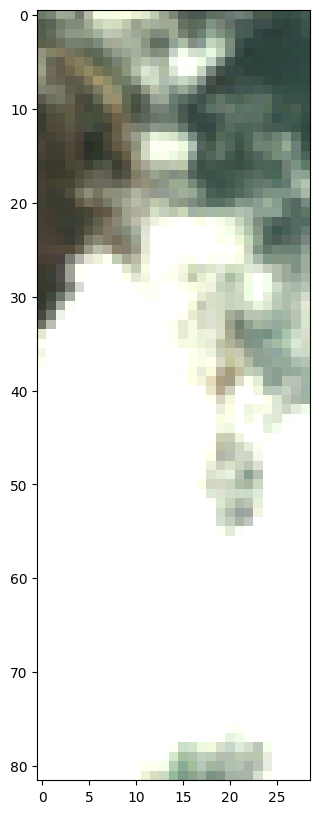

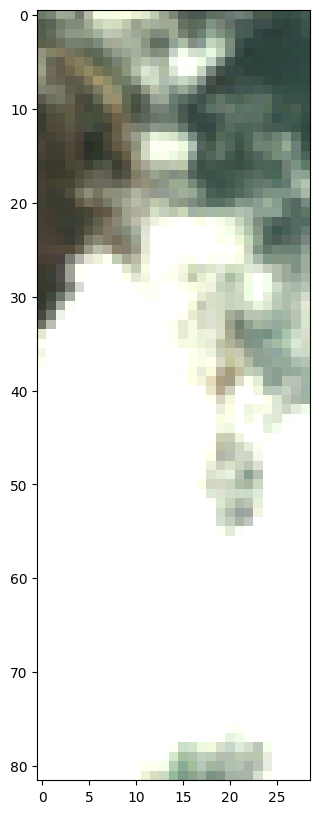

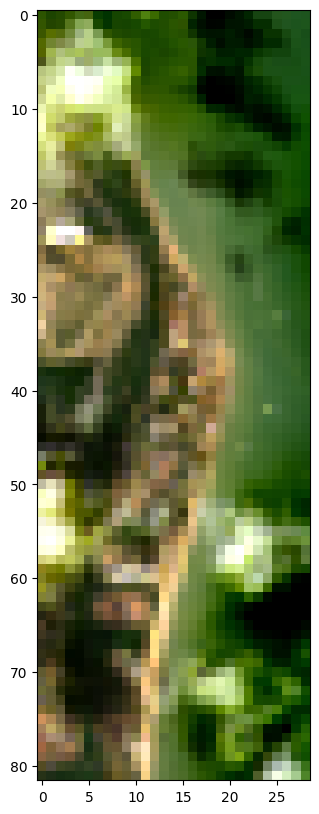

In [ ]:
REGION = 'Seixas'

# MUITA NUVEM: /content/drive/MyDrive/Seixas23/6B/2013/seixas23_20130525.SR_B2.tif
def get_RGB(date):

    year = date[:4]

    all_bands = tiff.imread('/content/drive/MyDrive/{}/original/6B/{}/{}_{}.tif'.format(REGION, year, REGION,  date))

    # Extract Blue, Green and Red (B4) bands
    if(year == "2009" or year == "2012" ): # Landsat 7
      B = all_bands[:,:,0]
      G = all_bands[:,:,1]
      R = all_bands[:,:,2]

    elif(int(year) < 2012): # Landsat 5 (the same of Landsat 5, just describing...)
      B = all_bands[:,:,0]
      G = all_bands[:,:,1]
      R = all_bands[:,:,2]

    else: # Landsat 8
      B = all_bands[:,:,1]
      G = all_bands[:,:,2]
      R = all_bands[:,:,3]

    # Stack and scale bands
    RGB = np.dstack((R, G, B))
    RGB = np.clip(RGB*0.0000275-0.2, 0, 1)

    # Clip to enhance contrast
    RGB = np.clip(RGB,0,0.3)/0.3

    return RGB

# Landsat 5 (1984–2012)
date = '19841219'
RGB = get_RGB(date)
print("LANDSAT 5", RGB.shape)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(RGB)

# date = '20090404'
RGB = get_RGB(date)
print("LANDSAT 7", RGB.shape)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(RGB)

# Landsat 8 (2013–Present)
date = '20240116'
RGB = get_RGB(date)
print("LANDSAT 8", RGB.shape)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(RGB)





In [ ]:
def get_QA(date):

    year = date[:4]

    all_bands = tiff.imread('/content/drive/MyDrive/{}/original/6B/{}/{}_{}.tif'.format(REGION, year, REGION, date))

    if(year == "2009" or year == "2012" ): # Landsat 7
      QA = all_bands[:,:,17]
    elif(int(year) < 2012): # Landsat 5 (the same of Landsat 5, just describing...)
      QA = all_bands[:,:,17]

    else: # Landsat 8
      QA = all_bands[:,:,18]

    return np.array(QA)

In [ ]:

def get_mask(val, type='cloud'):

    """Get mask for a specific cover type"""

    # convert to binary
    bin_ = '{0:016b}'.format(val)

    # reverse string
    str_bin = str(bin_)[::-1]

    bits = {'cloud':3,'shadow':4,'dilated_cloud':1,'cirrus':2}

    # # get bit for cover type
    # if year > 2012: # Landsat 8
    #   bits = {'cloud':3,'shadow':4,'dilated_cloud':1,'cirrus':2}
    # else:
    #   bits = {'cloud':3,'shadow':4,'dilated_cloud':1}

    bit = str_bin[bits[type]]

    if bit == '1':
        return 0 # cover
    else:
        return 1 # no cover

QA = get_QA(date)
cloud_mask = np.vectorize(get_mask)(QA,type='cloud')
shadow_mask = np.vectorize(get_mask)(QA,type='shadow')
dilated_cloud_mask = np.vectorize(get_mask)(QA,type='dilated_cloud')
cirrus_mask = np.vectorize(get_mask)(QA,type='cirrus')

# segmentation image
seg = RGB.copy()

# color for mask (white)
mask_color = np.array([255, 255, 255])
masks = [cloud_mask, shadow_mask, dilated_cloud_mask, cirrus_mask]

# create a black image with the same size as the original
mask_image = np.zeros_like(seg)

for mask in masks:
    # apply mask color
    mask_image[mask == 0] = mask_color

# save the mask image
cv2.imwrite('mask_image.png', mask_image)




True

In [ ]:
def get_binary_mask_from_path(path_image_6b):
    date = path_image_6b[-12:-4]
    QA = get_QA(date)
    cloud_mask = np.vectorize(get_mask)(QA,type='cloud')
    shadow_mask = np.vectorize(get_mask)(QA,type='shadow')
    dilated_cloud_mask = np.vectorize(get_mask)(QA,type='dilated_cloud')
    cirrus_mask = np.vectorize(get_mask)(QA,type='cirrus')

    # segmentation image
    seg = get_RGB(date)

    # color for mask (white)
    mask_color = np.array([255, 255, 255])
    masks = [cloud_mask, shadow_mask, dilated_cloud_mask, cirrus_mask]

    # create a black image with the same size as the original
    mask_image = np.zeros_like(seg)

    for mask in masks:
        # apply mask color
        mask_image[mask == 0] = mask_color
    path_scl = path_image_6b.replace('6B', 'SLC')
    save_full_path = path_scl.replace('.tif', '.png')
    # print()
    # save the mask image
    if(not os.path.exists(save_full_path[:-19])):
      os.makedirs(save_full_path[:-19])
    cv2.imwrite(save_full_path, mask_image)

get_binary_mask_from_path("/content/drive/MyDrive/Seixas/original/6B/2015/seixas_20151225.tif")




In [ ]:
i_year = 1984
f_year = 2024
initial_path = '/content/drive/MyDrive/Seixas/original/6B'
for year in range(i_year, f_year + 1):
    year_path = '/content/drive/MyDrive/Seixas/original/6B/{}/'.format(year)
    for image in os.listdir(year_path):
      full_path_image = os.path.join(year_path, image)
      get_binary_mask_from_path(full_path_image)



# **Plot**

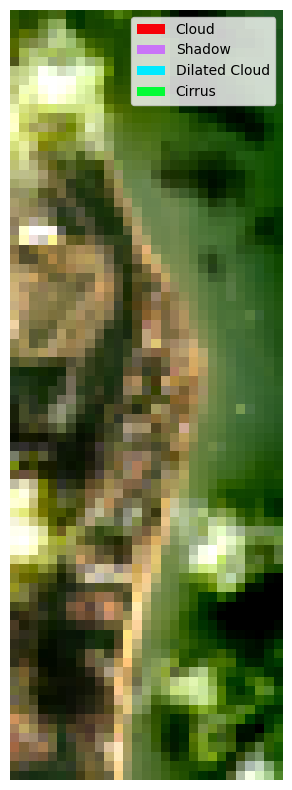

In [ ]:
import cv2
import matplotlib as mpl

# segmentation image
seg = RGB.copy()

# color for each cover type
colors = np.array([[247, 2, 7],
                    [201, 116, 247],
                    [0, 234, 255],
                    [3, 252, 53]])/255

masks = [cloud_mask, shadow_mask, dilated_cloud_mask, cirrus_mask]

for i,mask in enumerate(masks):

    # color for cover type
    temp = seg.copy()
    temp[mask == 0] = colors[i]

    # add to segmentation
    seg = cv2.addWeighted(seg, 0.5, temp, 0.5, 0)

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(seg)

# add legend with colors for each cover type
legend_elements = [mpl.patches.Patch(facecolor=colors[0], label='Cloud'),
                     mpl.patches.Patch(facecolor=colors[1], label='Shadow'),
                        mpl.patches.Patch(facecolor=colors[2], label='Dilated Cloud'),
                        mpl.patches.Patch(facecolor=colors[3], label='Cirrus')]

ax.legend(handles=legend_elements, loc='upper right')

ax.set_axis_off()


In [ ]:
!pip install rasterio

import rasterio

LANDSAT 8 (82, 29, 3)


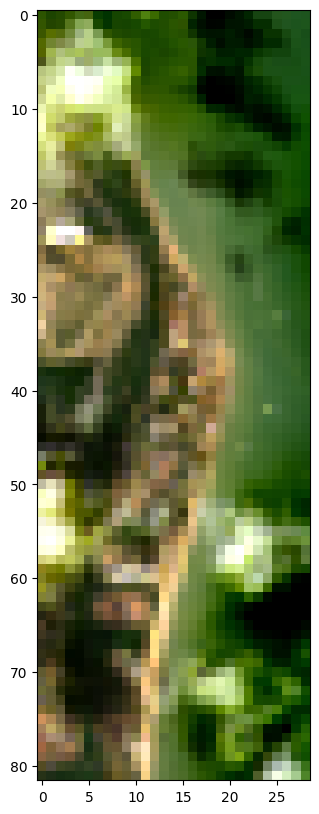

In [ ]:
# Landsat 8 (2013–Present)
date = '20240116'
RGB = get_RGB(date)
print("LANDSAT 8", RGB.shape)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(RGB)

LANDSAT 8 (82, 29, 3)


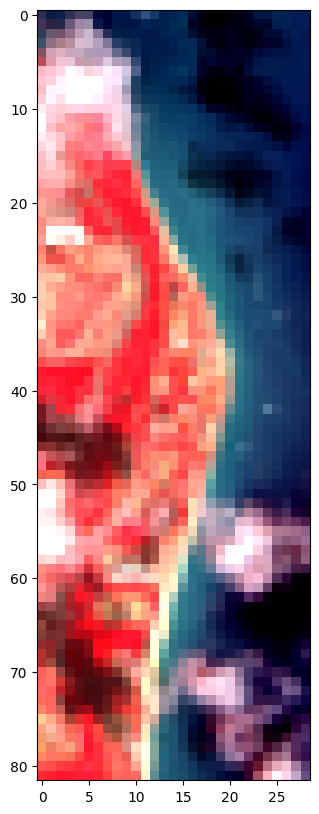

In [ ]:

def r_idx_bands(path):
    with rasterio.open(path) as src:

        # Lê as bandas
        bandas = src.read()

        # Remove a banda ultra blue (índice 0)
        bandas_reindexadas = bandas[1:]
        # Atualiza o campo 'count' nos metadados
        metadados_atualizados = src.meta.copy()
        metadados_atualizados.update({'count': bandas_reindexadas.shape[0]})

        with rasterio.open(path, 'w', **metadados_atualizados) as dst:
            dst.write(bandas_reindexadas)


path = "/content/drive/MyDrive/Seixas/original/6B/"
list_years = [str(year) for year in range(2013, 2025)]

for year in list_years:
   for file in os.listdir(path + str(year)):
       if(file.find("tif") != -1 ):
          r_idx_bands(os.path.join(path, str(year), file))

# Landsat 8 (2013–Present)
date = '20240116'
RGB = get_RGB(date)
print("LANDSAT 8", RGB.shape)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(RGB)